# Imports

In [4]:
import numpy as np
import dedalus.public as d3
from matplotlib import pyplot as plt

import os
import sys
sys.path.insert(0, '/home/disk/eos7/sressel/research/thesis-work/python/auxiliary_functions/')
import ipynb.fs.full.mjo_mean_state_diagnostics as mjo

import logging
logger = logging.getLogger(__name__)

# System setup

In [24]:
# Parameters
GRAVITY = 9.81                           # g [m/s^2]
EQUIVALENT_DEPTH = 250.                  # H [m]
CORIOLIS_PARAMETER = 2.29e-11            # ß [m^-1 s^-1]
EARTH_RADIUS = 6371.0072e3               # R_e [m]
AIR_DENSITY = 1.225                      # ρ_a [kg m^-3]
WATER_DENSITY = 997                      # ρ_w [kg m^-3]
LATENT_HEAT = 2260000                    # L_v [J kg^-1 K^-1]
SPECIFIC_HEAT = 1004                     # c_p [J kg^-1]
SECONDS_PER_DAY = 24*3600
GROSS_DRY_STABILITY = 3.12e4 

Lx = 2*np.pi*EARTH_RADIUS
Ly = 10000e3
Nx = 256
Ny = 256
gravity_wave_phase_speed = np.sqrt(GRAVITY*EQUIVALENT_DEPTH)
length_scale = (gravity_wave_phase_speed/CORIOLIS_PARAMETER)**(1/2)

dealias = 3/2
stop_sim_time = 1*SECONDS_PER_DAY
timestepper = d3.RK222
timestep = 500
dtype = np.float64

total_iterations = stop_sim_time//timestep

CFL = gravity_wave_phase_speed*timestep/(Lx/Nx)
print(f"CFL = {CFL:0.3f}")

# Bases
cartesian_coords = d3.CartesianCoordinates('x', 'y')
cartesian_dist = d3.Distributor(cartesian_coords, dtype=dtype)
xbasis = d3.RealFourier(cartesian_coords['x'], size=Nx, bounds=(0, Lx), dealias=dealias)
ybasis = d3.Chebyshev(cartesian_coords['y'], size=Ny, bounds=(-Ly, Ly), dealias=dealias)
x, y = dist.local_grids(xbasis, ybasis)

# Fields
# s = dist.Field(name='s')
u = dist.Field(name='u', bases=(xbasis, ybasis))
v = dist.Field(name='v', bases=(xbasis, ybasis))
T = dist.Field(name='T', bases=(xbasis, ybasis))
# s = dist.Field(name='s')
tau_u1 = dist.Field(name='tau_u1', bases=xbasis)
tau_v1 = dist.Field(name='tau_v1', bases=xbasis)
tau_T1 = dist.Field(name='tau_T1', bases=xbasis)
# tau_u2 = dist.Field(name='tau_u2', bases=xbasis)
tau_v2 = dist.Field(name='tau_v2', bases=xbasis)
# tau_T2 = dist.Field(name='tau_T2', bases=xbasis)

ncc_y = dist.Field(bases=ybasis)
ncc_y['g'] = y


# Substitutions
# dt = lambda A: s*A
dx = lambda A: d3.Differentiate(A, coords['x'])
dy = lambda A: d3.Differentiate(A, coords['y'])

# Problem
# problem = d3.IVP([u, v, T, tau_u1, tau_u2, tau_v1, tau_v2, tau_T1, tau_T2], namespace=locals())
# problem = d3.IVP([u, v, T, tau_u1, tau_T1, tau_v1, tau_v2], namespace=locals())
problem = d3.IVP([u, v, T, tau_T1, tau_u1, tau_v1], namespace=locals())
# problem = d3.EVP([u, v, T, tau_u1, tau_T1, tau_v1, tau_v2], eigenvalue = s, namespace=locals())

# Tau polynomials
tau_basis = ybasis.derivative_basis(1)
p_u1 = dist.Field(bases=tau_basis)
p_v1 = dist.Field(bases=tau_basis)
p_T1 = dist.Field(bases=tau_basis)
# p_u2 = dist.Field(bases=tau_basis)
p_v2 = dist.Field(bases=tau_basis)
# p_T2 = dist.Field(bases=tau_basis)

p_u1['c'][:, -1] = 1
p_v1['c'][:, -2] = 2
p_T1['c'][:, -3] = 3
# p_u2['c'][:, -4] = 4
p_v2['c'][:, -5] = 5
# p_T2['c'][:, -6] = 6

# Governing Equations
problem.add_equation(
    "dt(u) - CORIOLIS_PARAMETER*ncc_y*v + (gravity_wave_phase_speed**2/GROSS_DRY_STABILITY)*dx(T) + tau_u1*p_u1 = 0"
)
# problem.add_equation(
#     "dt(u) - CORIOLIS_PARAMETER*ncc_y*v + (gravity_wave_phase_speed**2/GROSS_DRY_STABILITY)*dx(T) = 0"
# )
problem.add_equation(
    "dt(v) + CORIOLIS_PARAMETER*ncc_y*u + (gravity_wave_phase_speed**2/GROSS_DRY_STABILITY)*dy(T) + tau_v1*p_v1 = 0"
)
problem.add_equation(
    "dt(T) + (GROSS_DRY_STABILITY)*(dx(u) + dy(v)) + tau_T1*p_T1 = 0"
)
# problem.add_equation("ux - dx(x) + tau_ux*p_ = 0")

# Boundary conditions
# problem.add_equation("v(y=-Ly) = 0")
problem.add_equation("T(y=-Ly) = 0")
problem.add_equation("dx(u)(y=Ly) + dy(v)(y=Ly) = 0 ")
problem.add_equation("dx(u)(y=-Ly) + dy(v)(y=-Ly) = 0 ")
# problem.add_equation("v(y=Ly) = 0")
# problem.add_equation("CORIOLIS_PARAMETER*ncc_y(y=-Ly)*u(y=-Ly) + (gravity_wave_phase_speed**2/GROSS_DRY_STABILITY)*dy(T)(y=-Ly) = 0")
# problem.add_equation("CORIOLIS_PARAMETER*ncc_y(y=Ly)*u(y=Ly) + (gravity_wave_phase_speed**2/GROSS_DRY_STABILITY)*dy(T)(y=Ly) = 0")
# problem.add_equation("dy(T)(y=Ly) = 0")

# Initial Conditions
n_wavelengths = 2
initial_wavenumber = 2*np.pi*n_wavelengths/Lx

u['g'] = gravity_wave_phase_speed*np.real(
    mjo.parabolic_cylinder_function(y/length_scale, 0)
    * np.exp(1j*initial_wavenumber*x)
)

# <T>(x,y,t=0)
T['g'] = (GROSS_DRY_STABILITY/gravity_wave_phase_speed**2)*gravity_wave_phase_speed**2*np.real(
    mjo.parabolic_cylinder_function(y/length_scale, 0)
    * np.exp(1j*initial_wavenumber*x)
)

v['g'] = np.zeros_like(u['g'])

# Make snapshots folder
if not os.path.exists("./dry_Matsuno_wave"):
    os.mkdir("./dry_Matsuno_wave")


CFL = 0.158


# Build Solver

In [25]:
# # Solver
# solver = problem.build_solver()
# sp = solver.subproblems_by_group[(1, None)]
# solver.solve_dense(sp)

solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time

snapshots = solver.evaluator.add_file_handler('dry_Matsuno_wave/snapshots', sim_dt=0.5*SECONDS_PER_DAY)
snapshots.add_task(u, name='u')
snapshots.add_task(v, name='v')
snapshots.add_task(T, name='T')

2024-03-05 11:44:13,875 subsystems 0/1 INFO :: Building subproblem matrices 1/128 (~1%) Elapsed: 1s, Remaining: 1m 12s, Rate: 1.8e+00/s
2024-03-05 11:44:16,820 subsystems 0/1 INFO :: Building subproblem matrices 13/128 (~10%) Elapsed: 4s, Remaining: 31s, Rate: 3.7e+00/s
2024-03-05 11:44:19,738 subsystems 0/1 INFO :: Building subproblem matrices 26/128 (~20%) Elapsed: 6s, Remaining: 25s, Rate: 4.0e+00/s
2024-03-05 11:44:23,031 subsystems 0/1 INFO :: Building subproblem matrices 39/128 (~30%) Elapsed: 10s, Remaining: 22s, Rate: 4.0e+00/s
2024-03-05 11:44:23,434 subsystems 0/1 INFO :: Building subproblem matrices 42/128 (~33%) Elapsed: 10s, Remaining: 21s, Rate: 4.1e+00/s
2024-03-05 11:44:26,003 subsystems 0/1 INFO :: Building subproblem matrices 52/128 (~41%) Elapsed: 13s, Remaining: 19s, Rate: 4.1e+00/s
2024-03-05 11:44:29,005 subsystems 0/1 INFO :: Building subproblem matrices 65/128 (~51%) Elapsed: 16s, Remaining: 15s, Rate: 4.1e+00/s
2024-03-05 11:44:32,462 subsystems 0/1 INFO :: Bui

# Run Solver

In [26]:
# Main loop
try: 
    logger.info("Starting main loop")
    while solver.proceed:
        solver.step(timestep)
        if solver.iteration % 100 == 0:
            logger.info(
                f"Iteration={solver.iteration}/{total_iterations}, "
                + f"Time={solver.sim_time/SECONDS_PER_DAY:0.2f}/{stop_sim_time/SECONDS_PER_DAY} days, "
                + f"dt={timestep} sec"
            )
except:
    logger.error('Exception raised, triggering end of main loop')
    raise
finally:
    solver.log_stats()

2024-03-05 11:44:45,290 __main__ 0/1 INFO :: Starting main loop
2024-03-05 11:45:30,895 __main__ 0/1 INFO :: Iteration=100/172, Time=0.58/1.0 days, dt=500 sec
2024-03-05 11:45:57,183 solvers 0/1 INFO :: Simulation stop time reached.
2024-03-05 11:45:57,188 solvers 0/1 INFO :: Final iteration: 173
2024-03-05 11:45:57,189 solvers 0/1 INFO :: Final sim time: 86500.0
2024-03-05 11:45:57,191 solvers 0/1 INFO :: Setup time (init - iter 0): 35.67 sec
2024-03-05 11:45:57,194 solvers 0/1 INFO :: Warmup time (iter 0-10): 11.26 sec
2024-03-05 11:45:57,195 solvers 0/1 INFO :: Run time (iter 10-end): 60.52 sec
2024-03-05 11:45:57,197 solvers 0/1 INFO :: CPU time (iter 10-end): 0.01681 cpu-hr
2024-03-05 11:45:57,198 solvers 0/1 INFO :: Speed: 1.059e+06 mode-stages/cpu-sec


# Analysis

In [27]:
data = d3.load_tasks_to_xarray('dry_Matsuno_wave/snapshots/snapshots_s1.h5')
zonal_velocity = data['u']
meridional_velocity = data['v']
column_temperature = data['T']

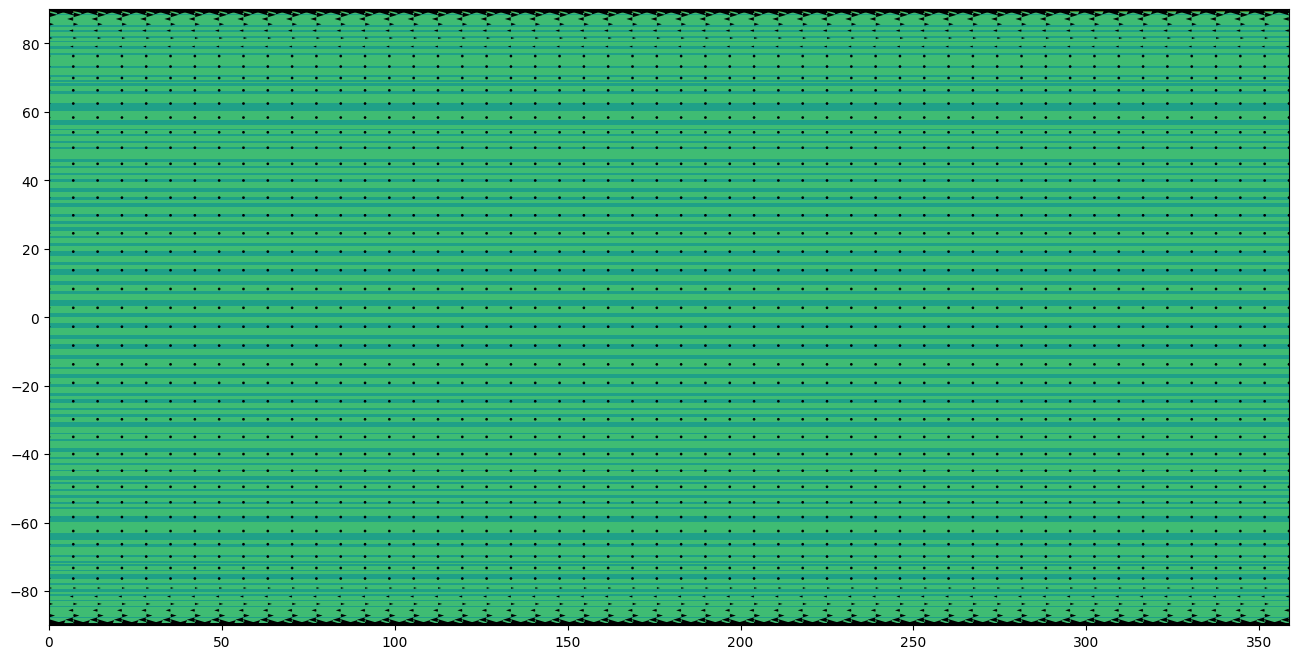

In [28]:
METERS_PER_DEGREE = 2*np.pi*EARTH_RADIUS/360
t = 1
plt.figure(figsize=(16,8))
plt.contourf(
    column_temperature.x/METERS_PER_DEGREE,
    column_temperature.y/METERS_PER_DEGREE,
    column_temperature.T.isel(t=t),
    # colors='k'
)

y_skip = 5
x_skip = 5
plt.quiver(
    zonal_velocity.x[::x_skip]/METERS_PER_DEGREE,
    zonal_velocity.y[::y_skip]/METERS_PER_DEGREE,
    zonal_velocity.T.isel(t=t)[::x_skip, ::y_skip],
    meridional_velocity.T.isel(t=t)[::x_skip, ::y_skip],
    # scale=1000
)
plt.show()